# **Vehicle and Bike Collision Avoidance Problem**

University of California Berkeley

These notes were developed by Hansung Kim, Charlott Vallon, Roya Firoozi and Francesco Borrelli at UC Berkeley. They are protected by U.S. copyright law and by University policy (https://copyright.universityofcalifornia.edu/resources/ownership-course-materials.html).

You may not reproduce, distribute or display (post/upload) lecture notes or recordings or course materials in any way — whether or not a fee is charged — without my express written consent. You also may not allow others to do so. If you do so, you may be subject to student conduct proceedings under the Berkeley Code of Student Conduct, including Sections 102.23 and 102.25.

# Problem Parameters

In [7]:
import numpy as np

#Scene parameters
d_bike      = 100  # m
w_bike  = 2    # m
l_car   = 4.5  #m
dsafe = d_bike - w_bike/2 - l_car/2

tmin   = 147   # s
tmax   = 150   # s

v_max   = 32      #m/s
g       = 9.81    #m/s^2
Ts      = 1       #s sampling time
nx = 2        # number of states
nu = 1         # number of inputs

# CFTOC Setup in Pyomo

In [8]:
# Setup the CTFOC problem using Pyomo
import pyomo.environ as pyo
from pyomo.opt import SolverStatus, TerminationCondition

def cftoc(x0, d_bike, N, mu, vref, Xf={'type':''},p={'type':''}):
  # x is state vector, u is input, Ts is sampling period.
  model = pyo.ConcreteModel()
  model.tidx = pyo.Set(initialize=range(0, N+1)) # length of finite optimization problem
  model.tidu = pyo.Set(initialize=range(0, N)) # length of finite optimization problem
  model.xidx = pyo.Set(initialize=range(0, nx))
  model.uidx = pyo.Set(initialize=range(0, nu))

  # Create state and input variables trajectory:
  model.x = pyo.Var(model.xidx, model.tidx)
  model.u = pyo.Var(model.uidx, model.tidu)

  # Tuning
  model.R=2
  model.Q=1

  # This code handles 3 types of terminal constraint: cvxhull, full-dimentional polytope, and terminal equality constraint
  if  Xf['type']=='cvxhull':
    model.nf = np.size(Xf['SS'], 0)
    model.nfidx = pyo.Set( initialize= range(model.nf), ordered=True )
    print( model.nf )
    model.SS = Xf['SS']
    model.lambdavar = pyo.Var(model.nfidx)

  if Xf['type']=='polytope':
    model.nf = np.size(Xf['Af'], 0)
    model.nfidx= pyo.Set( initialize= range(model.nf), ordered=True )
    model.Af = Xf['Af']
    model.bf = Xf['bf']

  if Xf['type']=='polytope_eq':
    model.nf = np.size(Xf['Aeq'], 0)
    model.nfidx= pyo.Set(initialize = range(model.nf), ordered=True )
    model.Aeq = Xf['Aeq']
    model.beq = Xf['beq']

  # This code handles 2 types of terminal cost: cvxhull, and quadratic cost
  if  p['type']=='cvxhull':
    model.cvalue=p['patsamples']

  if  p['type']=='quadratic':
    model.P=p['P']

  # Constraints:
  #Initial condition
  model.constraint1 = pyo.Constraint(model.xidx, rule=lambda model, i: model.x[i, 0] == x0[i])

  #State dynamics
  model.constraint2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[0, t+1] == model.x[0, t] + Ts*model.x[1, t]
                                    if t < N else pyo.Constraint.Skip)
  model.constraint3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1, t+1] == model.x[1, t] + Ts*model.u[0,t]
                                    if t < N else pyo.Constraint.Skip)

  #State bounds
  model.constraint4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1, t] >= 0) # non-strict inequalities not allowed
  model.constraint5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1, t] <= v_max) # Speed limit

  #Input bounds
  model.constraint6 = pyo.Constraint(model.tidu, rule=lambda model, t: model.u[0,t] >= -g*mu)
  model.constraint7 = pyo.Constraint(model.tidu, rule=lambda model, t: model.u[0,t] <= g*mu)

  #State constraints
  #model.constraint8 = pyo.Constraint(model.tidx, rule = lambda model, t: model.x[0,t] <= d_bike - w_bike/2-  l_car/2 )

  if  Xf['type']=='cvxhull':
    model.constraint9= pyo.Constraint(model.xidx, rule=lambda model, k: model.x[k,N] == sum( (model.SS[i,k] * model.lambdavar[i]) for i in model.nfidx))
    model.constraint10= pyo.Constraint(rule=lambda model: sum(model.lambdavar[i]  for i in model.nfidx)  == 1 )
    model.constraint11= pyo.Constraint(model.nfidx, rule=lambda model, i:   model.lambdavar[i]>=0)
  if  Xf['type']=='polytope':
    def final_const_rule(model, i):
        return sum(model.Af[i, j] * model.x[j, N] for j in model.xidx) <= model.bf[i]
    model.final_const = pyo.Constraint(model.nfidx, rule=final_const_rule)
  if  Xf['type']=='polytope_eq':
    def final_const_rule(model, i):
        return sum(model.Aeq[i, j] * model.x[j, N] for j in model.xidx) == model.beq[i]
    model.final_const = pyo.Constraint(model.nfidx, rule=final_const_rule)

  if p['type']=='cvxhull':
    #jerk minimization
    # model.cost = pyo.Objective(expr = sum((model.u[i, t+1]-model.u[i, t])**2 for i in model.uidx for t in model.tidx if t < N-1) + sum((model.x[1, t]-vref)**2 for t in model.tidx), sense=pyo.minimize)
    #acceleration minimization
    model.cost = pyo.Objective(expr = (sum(model.R*(model.u[0, t])**2  for t in model.tidu ) + sum(model.Q*(model.x[1, t]-vref)**2 for t in model.tidx) +sum((model.cvalue[i] * model.lambdavar[i]) for i in model.nfidx)), sense=pyo.minimize)
  elif  p['type']=='quadratic':
    model.cost = pyo.Objective(expr = (sum(model.R*(model.u[0, t])**2  for t in model.tidu ) + sum(model.Q*(model.x[1, t]-vref)**2 for t in model.tidu) +model.P*(model.x[1, N]-vref)**2), sense=pyo.minimize)
  else:
    model.cost = pyo.Objective(expr = (sum(model.R*(model.u[0, t])**2  for t in model.tidu ) + sum(model.Q*(model.x[1, t]-vref)**2 for t in model.tidu)), sense=pyo.minimize)

  # Now we can solve:
  results = pyo.SolverFactory('ipopt').solve(model)
  d = pyo.value(model.x[0,:])
  v = pyo.value(model.x[1,:])
  a = pyo.value(model.u[0,:])
  c = pyo.value(model.cost)

  return d, v, a, results.solver.termination_condition,c


# CFTOC Solution with Strategy A

In [9]:
import matplotlib.pyplot as plt
### Initialization
x0    = np.array([40,10]) #[position, velocity]
T     = tmax #task horizon
vref  = 20 #reference speed
mu    = 0.5     #road friction coefficient
allow_reverse=False
N = T # prediction horizon
########

# strategy A
# terminal region constraint : Af*xN <= bf
Af = np.array([[1, 0]])
bf = np.zeros((1, )) + dsafe
Xf={'type':'polytope','Af':Af,'bf':bf}
p={'type':'quadratic','P':1}
d, v, a, termination_condition,c = cftoc(x0,d_bike,N,mu,vref,Xf,p)

# plot results
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(d, v,'-og',label='Optimal solution over task T='+str(T)+', cost='+str(round(c)))
plt.axvline(x = dsafe, color = 'r', label = 'safety constraint')
plt.legend(fontsize=12)
plt.xlabel('d [m]', fontsize=24)
plt.ylabel('v [m/s]', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.show()

t_array = range(T+1)
f = plt.figure(figsize=(8,8))
plt.subplot(3,1,1)
plt.plot(t_array, d)
plt.plot(np.asarray(t_array), np.asarray(d)*0+ dsafe,'r--')
plt.ylabel('D (m)')
plt.subplot(3,1,2)
plt.plot(t_array, v)
plt.ylabel('v (m/s)')
plt.subplot(3,1,3)
plt.plot(t_array[:-1], a,'o')
plt.ylabel('a ($m/s^2$)')
plt.xlabel('t (s)')
plt.show()


ipopt


ApplicationError: No executable found for solver 'ipopt'

# CFTOC Solution with Strategy B

In [10]:
import matplotlib.pyplot as plt
### Initialization
x0    = np.array([40,10])
T     = tmin #task horizon
vref  = 20 # reference speed
mu    = 0.5     #road friction coefficient
allow_reverse=False
N=T # prediction horizon
########


# strategy B
# terminal equaity constraint: Aeq*xN == beq
Aeq = np.array([[1, 0],[0 , 1]])
beq = np.array([dsafe,0])
Xf={'type':'polytope_eq','Aeq':Aeq,'beq':beq}
p={'type':'quadratic','P':1}
d, v, a, termination_condition,c = cftoc(x0,d_bike,N,mu,vref,Xf)

# plot results
plt.figure(figsize=(8, 8), dpi=80)
plt.plot(d, v,'-og',label='Optimal solution over task T='+str(T)+', cost='+str(round(c)))
plt.axvline(x = dsafe, color = 'r', label = 'safety constraint')
plt.legend(fontsize=12)
plt.xlabel('d [m]', fontsize=24)
plt.ylabel('v [m/s]', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.show()

plt.figure(figsize=(8, 8), dpi=80)
t_array = range(T+1)
f = plt.figure(figsize=(5,5))
plt.subplot(3,1,1)
plt.plot(t_array, d)
plt.plot(np.asarray(t_array), np.asarray(d)*0+ dsafe,'r--')
plt.ylabel('d (m)')
#plt.xlim([0,30])
plt.subplot(3,1,2)
#plt.xlim([0,30])
plt.plot(t_array, v)
plt.ylabel('v (m/s)')
plt.subplot(3,1,3)
plt.plot(t_array[:-1], a,'o')
plt.ylabel('a ($m/s^2$)')
plt.xlabel('t (s)')
plt.show()


ipopt


ApplicationError: No executable found for solver 'ipopt'

# Sampled feasible initial conditions for the CFTOC problem A and B

In [11]:
######## GIVEN ###########
s0_min = 0; s0_max = d_bike
v0_min = 0; v0_max = v_max
s0_array = range(s0_min,s0_max,10)
v0_array = range(v0_min,v0_max+1)
mu = 0.5     #friction coefficient
vref = 20

##########################
# strategy A
# terminal constraint at the origin: Af*xN <= bf
TA=tmax
Af = np.array([[1, 0]])
bf = np.zeros((1, ))+ dsafe
XfA={'type':'polytope','Af':Af,'bf':bf}
pA={'type':'quadratic','P':1}

# strategy B
# terminal equaity constraint: Aeq*xN == beq
TB=tmin
Aeq = np.array([[1, 0],[0 , 1]])
beq = np.array([dsafe,0])
XfB={'type':'polytope_eq','Aeq':Aeq,'beq':beq}
pB={'type':'quadratic','P':1}


feasibility_matrixA = np.zeros((len(s0_array),len(v0_array)))
feasibility_matrixB = np.zeros((len(s0_array),len(v0_array)))
for s_ind, s0 in enumerate(s0_array):
  for v_ind, v0 in enumerate(v0_array):
    x0 = np.array([s0,v0])
    d, v, a, termination_conditionA,c = cftoc(x0,d_bike,TA,mu,vref,XfA,pA)
    d, v, a, termination_conditionB,c = cftoc(x0,d_bike,TB,mu,vref,XfB,pB)

    if termination_conditionA==TerminationCondition.optimal:
      feasibility_matrixA[s_ind,v_ind] = 1

    if termination_conditionB==TerminationCondition.optimal:
      feasibility_matrixB[s_ind,v_ind] = 1

import matplotlib.pyplot as plt
#Plot the feasibile parameter set
indA = np.argwhere(feasibility_matrixA==1)
indB = np.argwhere(feasibility_matrixB==1)
d0_feasA = [s0_array[i] for i in indA[:,0]]
v0_feasA = [v0_array[i] for i in indA[:,1]]
d0_feasB = [s0_array[i] for i in indB[:,0]]
v0_feasB = [v0_array[i] for i in indB[:,1]]

ipopt


ApplicationError: No executable found for solver 'ipopt'

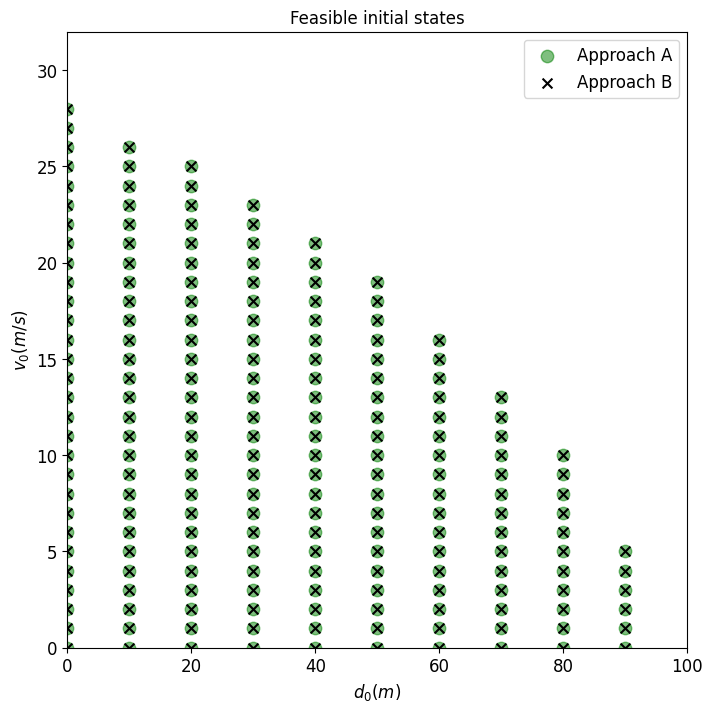

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(d0_feasA,v0_feasA,s=80,c='g',marker='o',alpha=0.5)
plt.scatter(d0_feasB,v0_feasB,s=50, c='k',marker='x')
plt.xlabel('$d_0 (m)$', fontsize=12)
plt.ylabel('$v_0 (m/s)$', fontsize=12)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlim([0,d_bike])
plt.ylim([v0_min,v0_max])
plt.legend(['Approach A','Approach B'], fontsize=12)
plt.title('Feasible initial states')
plt.show()

# MPC Core Algorithm
## system simulator  and closed loop simulation function


In [ ]:
from math import e
class SIMULATOR(object):
  def __init__(self, dt = 1, allow_reverse=False):
    # Define variables
    self.dt = dt
    self.allow_reverse = allow_reverse

  def sim(self, x, u):
    xnext=[x[0] + self.dt*x[1], x[1] + self.dt*u]
    xnext=np.asarray(xnext)
    if not self.allow_reverse:
      if xnext[1]>=0:
        return xnext.reshape(2, )
      else:
        xnext=[xnext[0],0]
        xnext=np.asarray(xnext)
        return xnext.reshape(2, )
    else:
      return xnext.reshape(2, )


In [ ]:
def sim_mpc(x0,N,T,vref,allow_reverse_flag,Xf={'type':''},p={'type':''}):

  #Storage vectors
  x_cl = np.empty(shape=(nx,T+1))
  x_cl[:, 0] = x0
  xPred = np.zeros((nx, N+1, T))
  uOpt = np.zeros((nu, T))
  feas = np.zeros((T, ), dtype=bool)
  cost = np.zeros((T, ))

  #initialize simulator
  simulator = SIMULATOR(dt=Ts,allow_reverse=allow_reverse_flag)

  # ====================================================================================
  # Run simulation with MPC in closed loop
  # ====================================================================================

  for t in range(T):
      # read current state
      xt = x_cl[:, t]
      d, v, a, termination_condition,c = cftoc(xt,d_bike,N,mu,vref,Xf,p)
      cost[t]=c

      if termination_condition==TerminationCondition.optimal:
        print('feasible at time t=',t)
        feas[t]=1
        # Save open loop predictions
        xPred[0, :, t] = d
        xPred[1, :, t] = v
        # Save optimal input
        uOpt[:, t] = a[0]
        # Simulate system with optimal input and save closed loop trajectory
        x_cl[:, t+1] = simulator.sim(x_cl[:, t], uOpt[:, t])
        #x_cl[:, t+1] = np.asarray([d[1],v[1]])

      else:
          print('infeasible at time t=',t)
          feas[t]=0
          #various options

          #Use Previous input
          #if t>0:
            #uOpt[:, t]=uOpt[:, t-1]

          #Use full break
          #uOpt[:, t]=-mu*g
          #x_cl[:, t+1] = simulator.sim(x_cl[:, t], uOpt[:, t])

          #just exit
          #x_cl = []
          #uOpt = []
          break

  return x_cl,uOpt,xPred,feas,cost




# Compute ${X}_0$ for MPC Stategy A

In [ ]:
# Define the range of initial parameters
from ttictoc import tic,toc

######## GIVEN ###########
s0_min = 0; s0_max = d_bike
v0_min = 0; v0_max = v_max
s0_array = range(s0_min,s0_max,10)
v0_array = range(v0_min,v0_max+1)
N       = 3      #Horizon
mu      = 0.5     #friction coefficient
vref=20
##########################
#strategy A
# terminal constraint at the origin: Af*xN <= bf
Af = np.array([[1, 0]])
bf = np.zeros((1, ))+d_bike - w_bike/2-  l_car/2
Xf={'type':'polytope','Af':Af,'bf':bf}
p={'type':'quadratic','P':1}

feasibility_matrix = np.zeros((len(s0_array),len(v0_array)))
print(feasibility_matrix.shape[0]*feasibility_matrix.shape[1])
tic()
for s_ind, s0 in enumerate(s0_array):
  for v_ind, v0 in enumerate(v0_array):
    x0 = np.array([s0,v0])
    d, v, a, termination_condition,c = cftoc(x0,d_bike,N,mu,vref,Xf,p)
    if termination_condition==TerminationCondition.optimal:
      feasibility_matrix[s_ind,v_ind] = 1
t_loop = toc()
print(f'The iterations took {t_loop} seconds')
import matplotlib.pyplot as plt
#Plot the feasibile parameter set
plt.figure(figsize=(10,10))
ind = np.argwhere(feasibility_matrix==1)
d0_feas = [s0_array[i] for i in ind[:,0]]
v0_feas = [v0_array[i] for i in ind[:,1]]


330


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally in

The iterations took 15.012044297999978 seconds


<Figure size 720x720 with 0 Axes>

# Compute ${O}_\infty$  for MPC strategy A

In [ ]:
#Define the range of initial parameters
from ttictoc import tic,toc
######## GIVEN ###########
s0_min = 0; s0_max = d_bike
v0_min = 0; v0_max = v_max
s0_array = range(s0_min,s0_max,10)
v0_array = range(v0_min,v0_max+1)
N       = 3      #Horizon
mu      =0.5     #road friction coefficient
vref=20
allow_reverse=False
Tstop     = 30 #simulation horizon (should really be very large; tried 150 and plot does not change)
##########################
#strategy A
# terminal constraint at the origin: Af*xN <= bf
Af = np.array([[1, 0]])
bf = np.zeros((1, ))+dsafe
Xf={'type':'polytope','Af':Af,'bf':bf}
p={'type':'quadratic','P':1}


feasibility_matrix = np.zeros((len(s0_array),len(v0_array)))
print(feasibility_matrix.shape[0]*feasibility_matrix.shape[1])
tic()
for s_ind, s0 in enumerate(s0_array):
  for v_ind, v0 in enumerate(v0_array):
    x0 = np.array([s0,v0])
    x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,Tstop,vref,allow_reverse,Xf,p)
    jm=sum(feas)
    if jm==Tstop:
      feasibility_matrix[s_ind,v_ind] = 1
t_loop = toc()
print(f'The iterations took {t_loop} seconds')
import matplotlib.pyplot as plt
#Plot the feasibile parameter set
plt.figure(figsize=(10,10))
ind = np.argwhere(feasibility_matrix==1)
d0_feas_cl = [s0_array[i] for i in ind[:,0]]
v0_feas_cl = [v0_array[i] for i in ind[:,1]]


330
feasible at time t= 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 6
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 6
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 6
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 5
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasibl

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasibl

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasibl

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasibl

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 3
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasibl

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasibl

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0
feasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 2
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1
feasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasibl

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 1


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasibl

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasibl

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasibl

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0
The iterations took 147.83096630899996 seconds


<Figure size 720x720 with 0 Axes>

# Plot ${X}_0$ and ${O}_\infty$ for strategy A

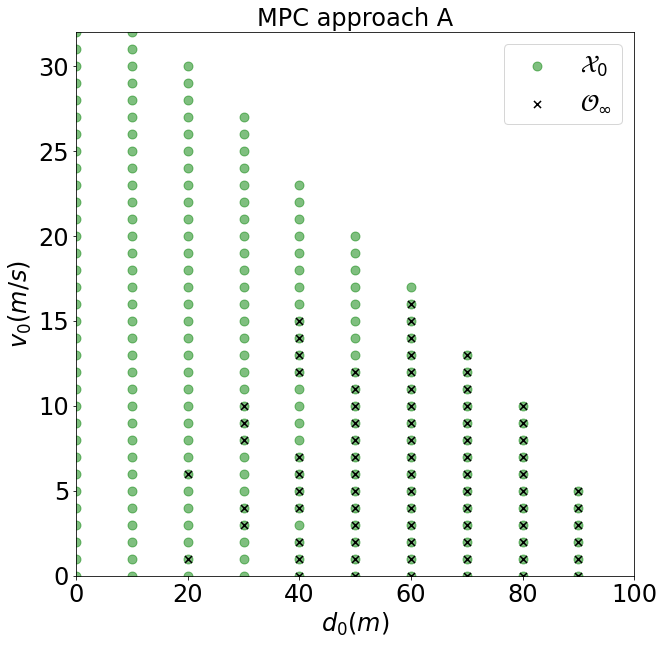

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(d0_feas,v0_feas,s=80,c='g',marker='o',alpha=0.5)
plt.scatter(d0_feas_cl,v0_feas_cl,s=50, c='k',marker='x')
plt.xlabel('$d_0 (m)$', fontsize=24)
plt.ylabel('$v_0 (m/s)$', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.legend(['$\mathcal{X}_0$','$\mathcal{O}_\infty$'], fontsize=24)
plt.title('MPC approach A', fontsize=24)
plt.xlim([0,d_bike])
plt.ylim([v0_min,v0_max])
plt.show()

# Plot Closed-Loop trajectories for MPC strategy A with different $N$

feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 4
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 30
feasible at time t= 31
feasible at time t= 32
feasible at time t= 33
feasible at time t= 34
feasible at time t= 35
feasible at time t= 36
feasible at time t= 37
feasible at time t= 38
feasible at time t= 39
feasible at time t= 40
feasible at time t= 41
feasible at time t= 42
feasible at time t= 43
feasible at time t= 44
feasible at time t= 45
feasible at time t= 46
feasible at time t= 47
feasible at time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 30
feasible at time t= 31
feasible at time t= 32
feasible at time t= 33
feasible at time t= 34
feasible at time t= 35
feasible at time t= 36
feasible at time t= 37
feasible at time t= 38
feasible at time t= 39
feasible at time t= 40
feasible at time t= 41
feasible at time t= 42
feasible at time t= 43
feasible at time t= 44
feasible at time t= 45
feasible at time t= 46
feasible at time 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


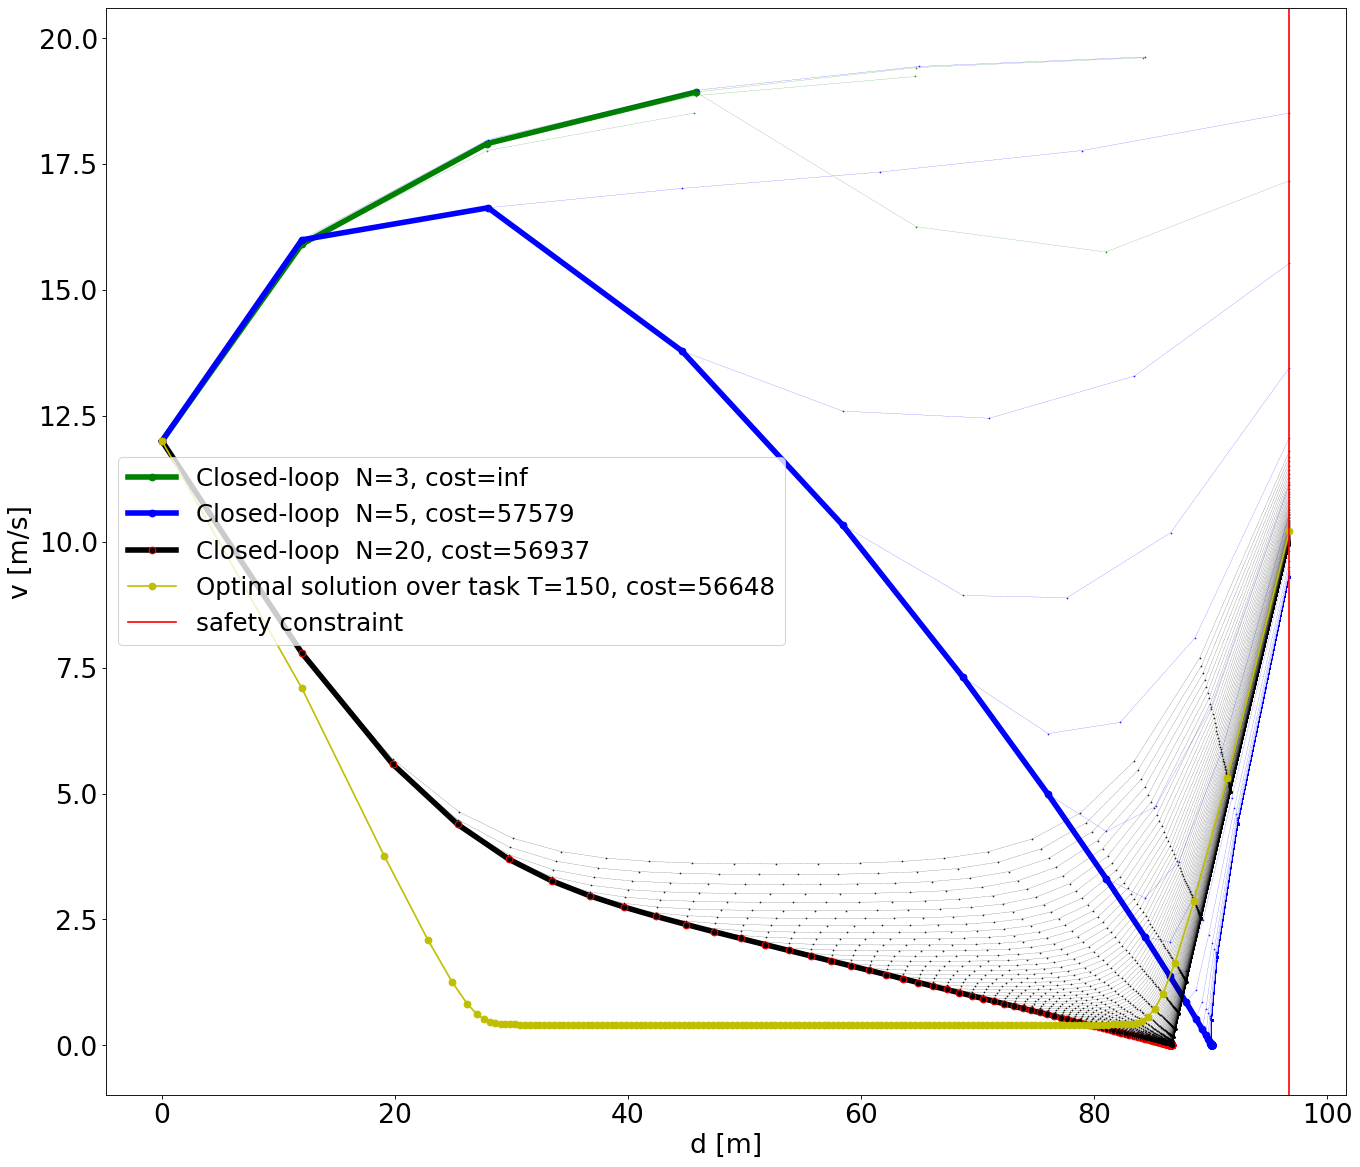

In [ ]:
import matplotlib.pyplot as plt
# MPC paramters

## case 1
x0    = np.array([0,12])
T     = 150 #simulation horizon
N     = 3 # Prediction horizon
vref  =20# reference speed
allow_reverse=False

# Stategy A
Af = np.array([[1, 0]])
bf = np.zeros((1, ))+d_bike - w_bike/2-  l_car/2
Xf={'type':'polytope','Af':Af,'bf':bf}
p={'type':'quadratic','P':1}

x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,T,vref,allow_reverse,Xf,p)
jm=sum(feas)
cost=0
if jm==T:
  for k in range(jm-1):
     cost=cost+(x_cl[1, k]-vref)**2+2*uOpt[0,k]**2
  cost=cost+(x_cl[1, jm]-vref)**2
else:
  cost=np.inf
plt.figure(figsize=(20, 18), dpi=80)
plt.plot(x_cl[0, 0:jm], x_cl[1, 0:jm], '-og', label='Closed-loop  N='+str(N)+', cost='+str(cost),linewidth=5)
for k in range(jm):
  plt.plot(xPred[0,:,k], xPred[1,:,k], '--og',linewidth=0.2,markersize=0.5)

## case 2
N=5
x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,T,vref,allow_reverse,Xf,p)
jm=sum(feas)
cost=0
if jm==T:
  for k in range(jm-1):
     cost=cost+(x_cl[1, k]-vref)**2+2*uOpt[0,k]**2
  cost=cost+(x_cl[1, jm]-vref)**2
else:
  cost=np.inf
plt.plot(x_cl[0, 0:jm], x_cl[1, 0:jm], '-ob', label='Closed-loop  N='+str(N)+', cost='+str(round(cost)),linewidth=5)
for k in range(jm):
  plt.plot(xPred[0,:,k], xPred[1,:,k], '--ob',linewidth=0.2,markersize=0.5)


## case 3
N=20
x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,T,vref,allow_reverse,Xf,p)
jm=sum(feas)
#compute closed loop cost
cost=0
if jm==T:
  for k in range(jm-1):
     cost=cost+(x_cl[1, k]-vref)**2+2*uOpt[0,k]**2
  cost=cost+(x_cl[1, jm]-vref)**2
  plt.plot(x_cl[0, 0:jm], x_cl[1, 0:jm], '-ok', markeredgecolor='r',label='Closed-loop  N='+str(N)+', cost='+str(round(cost)),linewidth=5)
else:
  cost=np.inf
  plt.plot(x_cl[0, 0:jm], x_cl[1, 0:jm], '-ok', markeredgecolor='r',label='Closed-loop  N='+str(N),linewidth=5)
#plot predictions
for k in range(jm):
  plt.plot(xPred[0,:,k], xPred[1,:,k], '--ok',linewidth=0.2,markersize=0.5)

## case 4
N=T
Tsim=1
x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,Tsim,vref,allow_reverse,Xf,p)
plt.plot(xPred[0,:,0], xPred[1,:,0],'-oy',label='Optimal solution over task T='+str(T)+', cost='+str(round(cost_cl[0])))



plt.axvline(x = d_bike - l_car/2 - w_bike/2, color = 'r', label = 'safety constraint')
plt.legend(fontsize=22)
plt.xlabel('d [m]', fontsize=24)
plt.ylabel('v [m/s]', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.show()


# Compute $\mathcal{X}_0$ and $\mathcal{O}_\infty$ for MPC  strategy B


330


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.
  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally in

The iterations took 29.326352313999962 seconds


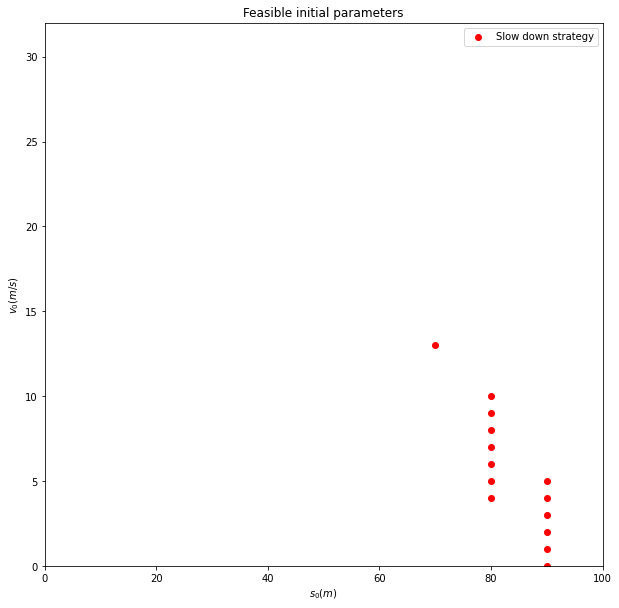

330


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0
feasible at time t= 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible a

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible a

  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0


  - termination condition: infeasible
  - message from solver: Ipopt 3.12.13\x3a Converged to a locally infeasible point. Problem may be infeasible.


infeasible at time t= 0
The iterations took 45.359242858000016 seconds


<Figure size 720x720 with 0 Axes>

In [ ]:
#Define the range of initial parameters
from ttictoc import tic,toc
######## GIVEN ###########
s0_min = 0; s0_max = d_bike
v0_min = 0; v0_max = v_max
s0_array = range(s0_min,s0_max,10)
v0_array = range(v0_min,v0_max+1)
N       = 3      #Horizon
mu      =0.5     #friction coefficient
vref=20
Tstop=20  #this shoudl really be infty... I tries 150 and set does not change
##########################

#strategy B
# terminal constraint at the origin: Aeq*xN == beq
Aeq = np.array([[1, 0],[0 , 1]])
beq = np.array([d_bike - w_bike/2-  l_car/2,0])
Xf={'type':'polytope_eq','Aeq':Aeq,'beq':beq}
p={'type':'quadratic','P':1}


# X0
feasibility_matrix = np.zeros((len(s0_array),len(v0_array)))
print(feasibility_matrix.shape[0]*feasibility_matrix.shape[1])
tic()
for s_ind, s0 in enumerate(s0_array):
  for v_ind, v0 in enumerate(v0_array):
    x0 = np.array([s0,v0])
    d, v, a, termination_condition,c = cftoc(x0,d_bike,N,mu,vref,Xf,p)
    if termination_condition==TerminationCondition.optimal:
      feasibility_matrix[s_ind,v_ind] = 1
t_loop = toc()
print(f'The iterations took {t_loop} seconds')
import matplotlib.pyplot as plt
#Plot the feasibile parameter set
plt.figure(figsize=(10,10))
ind = np.argwhere(feasibility_matrix==1)
d0_feas = [s0_array[i] for i in ind[:,0]]
v0_feas = [v0_array[i] for i in ind[:,1]]

plt.scatter(d0_feas,v0_feas,c='r')
plt.xlabel('$s_0 (m)$')
plt.ylabel('$v_0 (m/s)$')
plt.xlim([0,d_bike])
plt.ylim([v0_min,v0_max])
plt.legend(['Slow down strategy'])
plt.title('Feasible initial parameters')
plt.show()

# Oinf
feasibility_matrix = np.zeros((len(s0_array),len(v0_array)))
print(feasibility_matrix.shape[0]*feasibility_matrix.shape[1])
tic()
for s_ind, s0 in enumerate(s0_array):
  for v_ind, v0 in enumerate(v0_array):
    x0 = np.array([s0,v0])
    x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,Tstop,vref,allow_reverse,Xf,p)
    jm=sum(feas)
    if jm==Tstop:
      feasibility_matrix[s_ind,v_ind] = 1
t_loop = toc()
print(f'The iterations took {t_loop} seconds')
import matplotlib.pyplot as plt
#Plot the feasibile parameter set
plt.figure(figsize=(10,10))
ind = np.argwhere(feasibility_matrix==1)
d0_feas_cl = [s0_array[i] for i in ind[:,0]]
v0_feas_cl = [v0_array[i] for i in ind[:,1]]



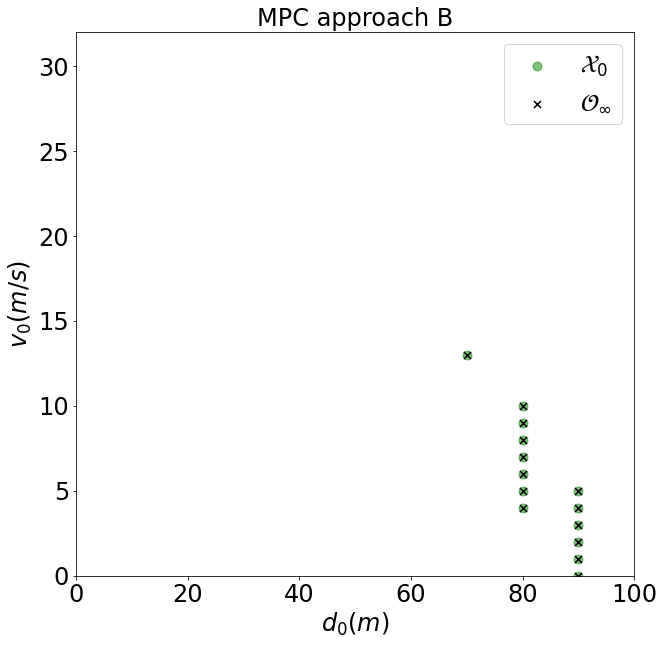

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(d0_feas,v0_feas,s=80,c='g',marker='o',alpha=0.5)
plt.scatter(d0_feas_cl,v0_feas_cl,s=50, c='k',marker='x')
plt.xlabel('$d_0 (m)$', fontsize=24)
plt.ylabel('$v_0 (m/s)$', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.legend(['$\mathcal{X}_0$','$\mathcal{O}_\infty$'], fontsize=24)
plt.title('MPC approach B', fontsize=24)
plt.xlim([0,d_bike])
plt.ylim([v0_min,v0_max])
plt.show()


# Plot Closed-Loop trajectories for MPC strategy B with different $N$



feasible at time t= 0
feasible at time t= 1
feasible at time t= 2
feasible at time t= 3
feasible at time t= 4


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 30
feasible at time t= 31
feasible at time t= 32
feasible at time t= 33
feasible at time t= 34
feasible at time t= 35
feasible at time t= 36
feasible at time t= 37
feasible at time t= 38
feasible at time t= 39
feasible at time t= 40
feasible at time t= 41
feasible at time t= 42
feasible at time t= 43
feasible at time t= 44
feasible at time t= 45
feasible at time t= 46
feasible at time t= 47
feasible at time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 30
feasible at time t= 31
feasible at time t= 32
feasible at time t= 33
feasible at time t= 34
feasible at time t= 35
feasible at time t= 36
feasible at time t= 37
feasible at time t= 38
feasible at time t= 39
feasible at time t= 40
feasible at time t= 41
feasible at time t= 42
feasible at time t= 43
feasible at time t= 44
feasible at time t= 45
feasible at time t= 46
feasible at time t= 47
feasible at time

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


feasible at time t= 4
feasible at time t= 5
feasible at time t= 6
feasible at time t= 7
feasible at time t= 8
feasible at time t= 9
feasible at time t= 10
feasible at time t= 11
feasible at time t= 12
feasible at time t= 13
feasible at time t= 14
feasible at time t= 15
feasible at time t= 16
feasible at time t= 17
feasible at time t= 18
feasible at time t= 19
feasible at time t= 20
feasible at time t= 21
feasible at time t= 22
feasible at time t= 23
feasible at time t= 24
feasible at time t= 25
feasible at time t= 26
feasible at time t= 27
feasible at time t= 28
feasible at time t= 29
feasible at time t= 30
feasible at time t= 31
feasible at time t= 32
feasible at time t= 33
feasible at time t= 34
feasible at time t= 35
feasible at time t= 36
feasible at time t= 37
feasible at time t= 38
feasible at time t= 39
feasible at time t= 40
feasible at time t= 41
feasible at time t= 42
feasible at time t= 43
feasible at time t= 44
feasible at time t= 45
feasible at time t= 46
feasible at time 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


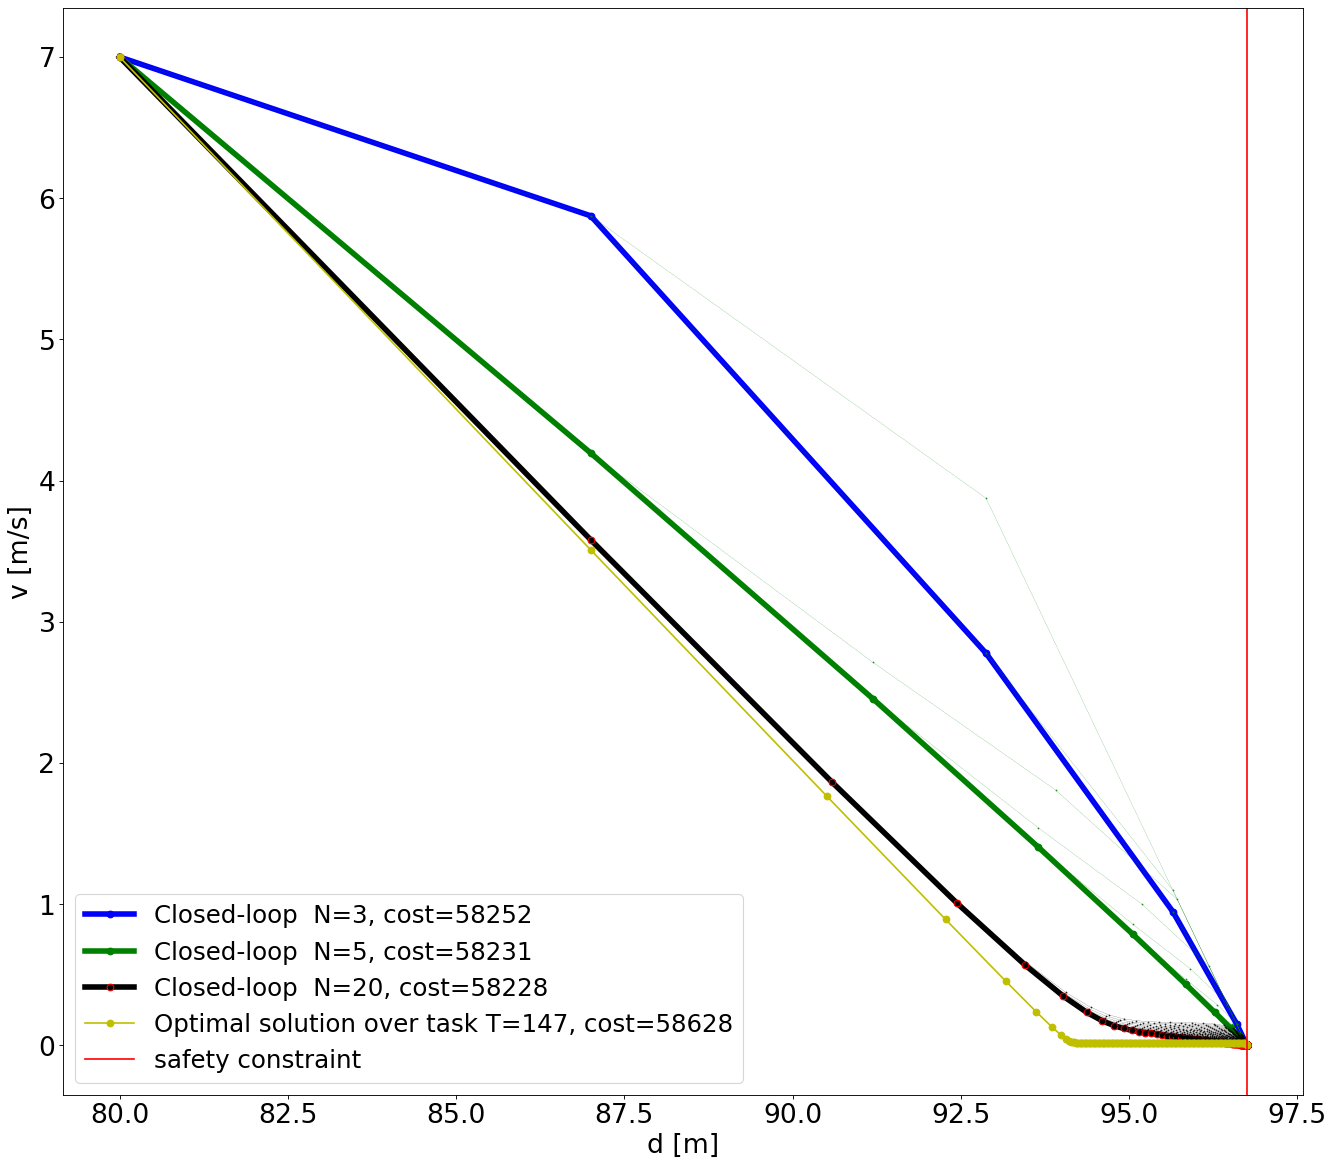

In [ ]:
import matplotlib.pyplot as plt
# MPC paramters


#strategy B
# terminal constraint at the origin: Aeq*xN == beq
Aeq = np.array([[1, 0],[0 , 1]])
beq = np.array([dsafe,0])
Xf={'type':'polytope_eq','Aeq':Aeq,'beq':beq}
p={'type':'quadratic','P':1}

## case 1
x0    = np.array([80,7])
T     = tmin #simulation horizon
N     = 3 # Prediction horizon
vref  = 20# reference speed
allow_reverse=False

plt.figure(figsize=(20, 18), dpi=80)
x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,T,vref,allow_reverse,Xf,p)
jm=sum(feas)
cost=0
if jm==T:
  for k in range(jm-1):
     cost=cost+(x_cl[1, k]-vref)**2+2*uOpt[0,k]**2
  cost=cost+(x_cl[1, jm]-vref)**2
  plt.plot(x_cl[0, 0:jm], x_cl[1, 0:jm], '-ob', label='Closed-loop  N='+str(N)+', cost='+str(round(cost)),linewidth=5)
else:
  cost=np.inf
  plt.plot(x_cl[0, 0:jm], x_cl[1, 0:jm], '-ob', label='Closed-loop  N='+str(N)+', cost=inf',linewidth=5)

for k in range(jm):
  plt.plot(xPred[0,:,k], xPred[1,:,k], '--og',linewidth=0.2,markersize=0.5)

## case 2
N=5
x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,T,vref,allow_reverse,Xf,p)
jm=sum(feas)
cost=0
if jm==T:
  for k in range(jm-1):
     cost=cost+(x_cl[1, k]-vref)**2+2*uOpt[0,k]**2
  cost=cost+(x_cl[1, jm]-vref)**2
  plt.plot(x_cl[0, 0:jm], x_cl[1, 0:jm], '-og', label='Closed-loop  N='+str(N)+', cost='+str(round(cost)),linewidth=5)
else:
  cost=np.inf
  plt.plot(x_cl[0, 0:jm], x_cl[1, 0:jm], '-og', label='Closed-loop  N='+str(N)+', cost=inf',linewidth=5)
for k in range(jm):
  plt.plot(xPred[0,:,k], xPred[1,:,k], '--og',linewidth=0.2,markersize=0.5)


## case 3
N=20
x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,T,vref,allow_reverse,Xf,p)
jm=sum(feas)
#compute closed loop cost
cost=0
if jm==T:
  for k in range(jm-1):
     cost=cost+(x_cl[1, k]-vref)**2+2*uOpt[0,k]**2
  cost=cost+(x_cl[1, jm]-vref)**2
  plt.plot(x_cl[0, 0:jm], x_cl[1, 0:jm], '-ok', markeredgecolor='r',label='Closed-loop  N='+str(N)+', cost='+str(round(cost)),linewidth=5)
else:
  cost=np.inf
  plt.plot(x_cl[0, 0:jm], x_cl[1, 0:jm], '-ok', markeredgecolor='r',label='Closed-loop  N='+str(N)+', cost=inf',linewidth=5)

#plot predictions
for k in range(jm):
  plt.plot(xPred[0,:,k], xPred[1,:,k], '--ok',linewidth=0.2,markersize=0.5)

## case 4
N=T
Tsim=1
x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,Tsim,vref,allow_reverse,Xf,p)
plt.plot(xPred[0,:,0], xPred[1,:,0],'-oy',label='Optimal solution over task T='+str(T)+', cost='+str(round(cost_cl[0])))


plt.axvline(x = dsafe, color = 'r', label = 'safety constraint')
plt.legend(fontsize=22)
plt.xlabel('d [m]', fontsize=24)
plt.ylabel('v [m/s]', fontsize=24)
plt.tick_params(axis='x', labelsize=24)
plt.tick_params(axis='y', labelsize=24)
plt.show()


################################################
# Compute X0 Set for MPC
###############################################

In [ ]:
import numpy as np
import scipy.signal
import scipy.linalg
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import polytope as pt

# Helper Function:

def minkowski_sum(X, Y):

    # Minkowski sum between two polytopes based on
    # vertex enumeration. So, it's not fast for the
    # high dimensional polytopes with lots of vertices.
    V_sum = []
    if isinstance(X, pt.Polytope):
        V1 = pt.extreme(X)
    else:
        # assuming vertices are in (N x d) shape. N # of vertices, d dimension
        V1 = X

    if isinstance(Y, pt.Polytope):
        V2 = pt.extreme(Y)
    else:
        V2 = Y

    for i in range(V1.shape[0]):
        for j in range(V2.shape[0]):
            V_sum.append(V1[i,:] + V2[j,:])
    return pt.qhull(np.asarray(V_sum))

# The operation Pre(S) results in the set of states which evolve into the target set S in one time step.
def precursor(Xset, A, Uset=pt.Polytope(), B=np.array([])):
        if not B.any():
            return pt.Polytope(Xset.A @ A, Xset.b)
        else:
            tmp  = minkowski_sum( Xset, pt.extreme(Uset) @ -B.T )
        return pt.Polytope(tmp.A @ A, tmp.b)



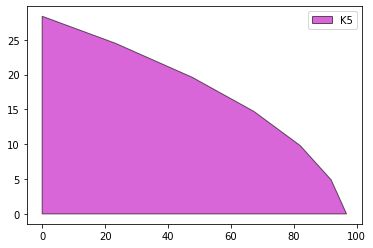

In [ ]:
##############################################
#let's focus on approach A and compue X0 for MPC
#################################################


#Recall
#State dynamics
#model.constraint2 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[0, t+1] == model.x[0, t] + Ts*model.x[1, t]
#model.constraint3 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1, t+1] == model.x[1, t] + Ts*model.u[0,t]
#State bounds
#model.constraint4 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1, t] >= 0) # non-strict inequalities not allowed
#model.constraint5 = pyo.Constraint(model.tidx, rule=lambda model, t: model.x[1, t] <= v_max) # Speed limit
#Input bounds
#model.constraint6 = pyo.Constraint(model.tidu, rule=lambda model, t: model.u[0,t] >= -g*mu)
#model.constraint7 = pyo.Constraint(model.tidu, rule=lambda model, t: model.u[0,t] <= g*mu)

# System dynamics
# x(k+1) = A*x(k) + B*u(k)

mu=0.5
A = np.array([[1, Ts],
               [0,  1]])
B = np.array([[0],
               [Ts]])

# constraint sets represented as polyhedra
# state constraint
X = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1.0, 0],
                          [0, -1.0]]),
                np.array([[dsafe],
                          [v_max],
                          [0],
                          [0]]))
# input constraint
U = pt.Polytope(np.array([1, -1]).reshape(2,1),
                np.array([g*mu, g*mu]).reshape(2,1))


# target set

S = pt.Polytope(np.array([[1.0, 0],
                          [0, 1.0],
                          [-1.0, 0],
                          [0, -1.0]]),
                np.array([[dsafe],
                          [v_max],
                          [0],
                          [0]]))

N = 6  # Prediction horizon
K = {}
PreS = precursor(S, A, U, B)
for j in range(N):
    K[j]= PreS.intersect(X)
    PreS = precursor(K[j], A, U, B)

# Plotting
plt.clf()
plt.cla()
plt.close('all')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

#K[0].plot(ax, color='m', alpha=0.1, linestyle='solid', linewidth=1, edgecolor=None)      # K_0 is equivalent to the target set S
#K[1].plot(ax, color='m', alpha=0.2, linestyle='solid', linewidth=1)                      # K_1 one step controllable set
#K[2].plot(ax, color='m', alpha=0.3, linestyle='solid', linewidth=1)                      # K_2 two step controllable set
#K[3].plot(ax, color='m', alpha=0.4, linestyle='solid', linewidth=1)                      # K_3
#K[4].plot(ax, color='m', alpha=0.5, linestyle='solid', linewidth=1)                      # K_4
K[5].plot(ax, color='m', alpha=0.6, linestyle='solid', linewidth=1)                      # K_5
#ax.legend(['K0', 'K1', 'K2', 'K3', 'K4', 'K5'])
ax.legend(['K5'])

ax.autoscale_view()
# ax.axis('equal')
plt.show()


##############################################
# Now design a LQR  controller , compute Oinf for the closed loop system and P and then use this terminal set and terminal cost a  MPC controller

#################################################



################################
# Advanced: Compute Sampled Invariant
################################


840
The iterations took 0.0387799239999822 seconds


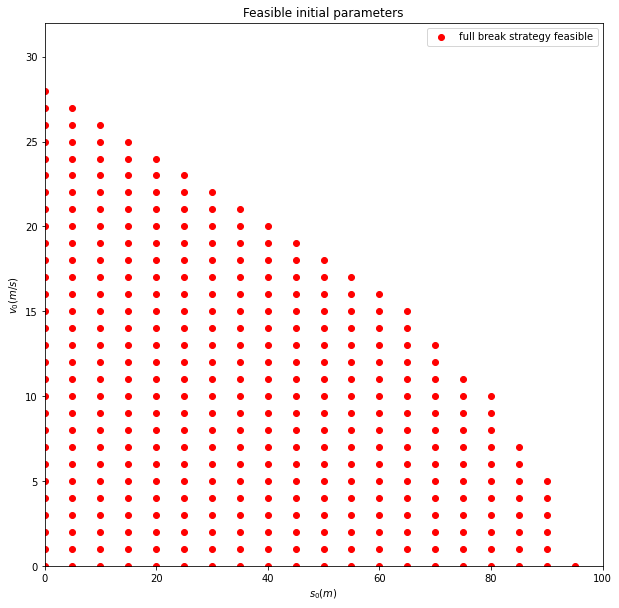

In [ ]:
#Define the range of initial parameters
from ttictoc import tic,toc
s0_min = 0; s0_max = d_bike
v0_min = 0; v0_max = v_max
s0_array = range(s0_min,s0_max,5)
v0_array = range(v0_min,v0_max+10)
N       = 3      #Horizon
mu      = 0.5
vref=15
Tsim=150
##########################
allow_reverse=False
simulator = SIMULATOR(dt=Ts,allow_reverse=allow_reverse)

points=[];
costs=[]
feasibility_matrix = np.zeros((len(s0_array),len(v0_array)))
print(feasibility_matrix.shape[0]*feasibility_matrix.shape[1])
tic()
for s_ind, s0 in enumerate(s0_array):
  for v_ind, v0 in enumerate(v0_array):
    cost=0
    xk = np.array([s0,v0])
    sim_ended=False
    tmp_list=[]
    tmp_list.append([s0,v0])
    tmp_listc=[]
    cost=cost+(xk[1]-vref)**2+2*(-mu*g)**2
    tmp_listc.append(cost)
    for k in range (Tsim):
        xk =simulator.sim(xk, -mu*g)
        cost=cost+(xk[1]-vref)**2+2*(-mu*g)**2
        tmp_listc.append(cost)
        tmp_list.append([xk[0],xk[1]])
        if xk[0]>d_bike - l_car/2 - w_bike:
          feasibility_matrix[s_ind,v_ind] = 0
          sim_ended=True
          break
        elif xk[1]<0.01:
          #vechile stopped
          feasibility_matrix[s_ind,v_ind] = 1
          costs.append(tmp_listc[::-1])
          points.append(tmp_list)
          sim_ended=True
          break
    if not sim_ended:
      if xk[0]>d_bike - l_car/2 - w_bike:
        feasibility_matrix[s_ind,v_ind] = 0
        break
      elif xk[1]<0.01:
        #vehicle stopped
        feasibility_matrix[s_ind,v_ind] = 1
        costs.append(tmp_listc[::-1])
        points.append(tmp_list)
      else:
        print('simulation too short')
        feasibility_matrix[s_ind,v_ind] = 0
t_loop = toc()
print(f'The iterations took {t_loop} seconds')

import matplotlib.pyplot as plt
#Plot the feasibile parameter set
plt.figure(figsize=(10,10))
ind = np.argwhere(feasibility_matrix==1)
d0_feas = [s0_array[i] for i in ind[:,0]]
v0_feas = [v0_array[i] for i in ind[:,1]]

plt.scatter(d0_feas,v0_feas,c='r')
plt.xlabel('$s_0 (m)$')
plt.ylabel('$v_0 (m/s)$')
plt.xlim([0,d_bike])
plt.ylim([v0_min,v0_max])
plt.legend(['full break strategy feasible'])
plt.title('Feasible initial parameters')
plt.show()

[   0 1209 1208 1207 1206 1205  123  122  121]
[546.2361    48.11805  120.295125 264.649275 529.29855  802.4166
 532.061    713.004675 986.122725]
(9, 2)


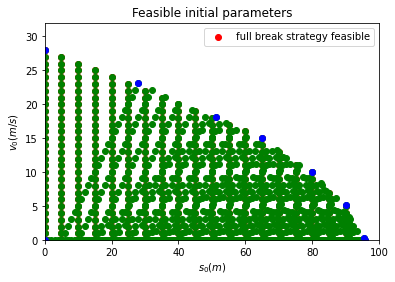

In [ ]:
#simplify and organize the dataset. V and cost_fun wll be the data that MPC needs

from scipy.spatial import ConvexHull, convex_hull_plot_2d
from itertools import chain
points=np.asarray(list(chain(*points)))
costs=np.asarray(list(chain(*costs)))
hull = ConvexHull(points)
HK=np.asarray(hull.equations)
H=HK[:,0:2]
K=HK[:,2]
print(hull.vertices)
V=points[hull.vertices]
cost_fun=costs[hull.vertices]
print(cost_fun)
print(V.shape)
plt.scatter(d0_feas,v0_feas,c='r')
plt.xlabel('$s_0 (m)$')
plt.ylabel('$v_0 (m/s)$')
plt.xlim([0,d_bike])
plt.ylim([v0_min,v0_max])
plt.legend(['full break strategy feasible'])
plt.title('Feasible initial parameters')
plt.scatter(points[:,0],points[:,1],c='g')
plt.scatter(V[:,0],V[:,1],c='b')
plt.show()


# Advanced: Design  MPC with  terminal set and terminal costs
## This follows the approach of the paper: https://www.sciencedirect.com/science/article/pii/S2405896317306523


9
feasible at time t= 0
9
feasible at time t= 1
9
feasible at time t= 2
9
feasible at time t= 3
9
feasible at time t= 4
9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


feasible at time t= 5
9
feasible at time t= 6
9
feasible at time t= 7
9
feasible at time t= 8
9
feasible at time t= 9
9
feasible at time t= 10
9
feasible at time t= 11
9
feasible at time t= 12
9
feasible at time t= 13
9
feasible at time t= 14
9
feasible at time t= 15
9
feasible at time t= 16
9
feasible at time t= 17
9
feasible at time t= 18
9
feasible at time t= 19
9
feasible at time t= 20
9
feasible at time t= 21
9
feasible at time t= 22
9
feasible at time t= 23
9
feasible at time t= 24
9
feasible at time t= 25
9
feasible at time t= 26
9
feasible at time t= 27
9
feasible at time t= 28
9
feasible at time t= 29
9
feasible at time t= 30
9
feasible at time t= 31
9
feasible at time t= 32
9
feasible at time t= 33
9
feasible at time t= 34
9
feasible at time t= 35
9
feasible at time t= 36
9
feasible at time t= 37
9
feasible at time t= 38
9
feasible at time t= 39
9
feasible at time t= 40
9
feasible at time t= 41
9
feasible at time t= 42
9
feasible at time t= 43
9
feasible at time t= 44
9
feasi

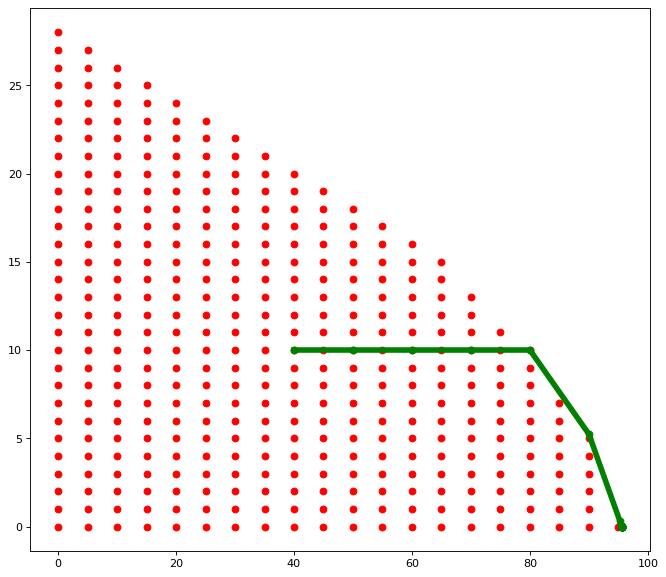

In [ ]:
## case 1
x0    = np.array([40,10])
T     = 50 #simulation horizon
N     = 1 # Prediction horizon
vref  =20 # reference speed
allow_reverse=False
simulator = SIMULATOR(dt=Ts,allow_reverse=allow_reverse)
Xf={'type':'cvxhull','SS':V}
p={'type':'cvxhull', 'patsamples':cost_fun}

# try with p and without p
#x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,T,vref,allow_reverse,Xf,p)
x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,T,vref,allow_reverse,Xf)
jm=sum(feas)
cost=0
if jm==T:
  for k in range(jm-1):
     cost=cost+(x_cl[1, k]-vref)**2+2*uOpt[0,k]**2
  cost=cost+(x_cl[1, jm]-vref)**2
else:
  cost=np.inf
plt.figure(figsize=(10, 9), dpi=80)
plt.scatter(d0_feas,v0_feas,c='r')
plt.plot(x_cl[0, 0:jm], x_cl[1, 0:jm], '-og', label='Closed-loop  N='+str(N)+', cost='+str(cost),linewidth=5)
for k in range(jm):
  plt.plot(xPred[0,:,k], xPred[1,:,k], '--og',linewidth=0.2,markersize=0.5)




# Advanced: Compute and plot closed-loop trajectories as function  of time when the MPC controller with invariant terminal set and CLF termial cost is used


9
feasible at time t= 0
9
feasible at time t= 1
9
feasible at time t= 2
9
feasible at time t= 3
9
feasible at time t= 4
9


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


feasible at time t= 5
9
feasible at time t= 6
9
feasible at time t= 7
9
feasible at time t= 8
9
feasible at time t= 9
9
feasible at time t= 10
9
feasible at time t= 11
9
feasible at time t= 12
9
feasible at time t= 13
9
feasible at time t= 14
9
feasible at time t= 15
9
feasible at time t= 16
9
feasible at time t= 17
9
feasible at time t= 18
9
feasible at time t= 19
9
feasible at time t= 20
9
feasible at time t= 21
9
feasible at time t= 22
9
feasible at time t= 23
9
feasible at time t= 24
9
feasible at time t= 25
9
feasible at time t= 26
9
feasible at time t= 27
9
feasible at time t= 28
9
feasible at time t= 29
9
feasible at time t= 30
9
feasible at time t= 31
9
feasible at time t= 32
9
feasible at time t= 33
9
feasible at time t= 34
9
feasible at time t= 35
9
feasible at time t= 36
9
feasible at time t= 37
9
feasible at time t= 38
9
feasible at time t= 39
9
feasible at time t= 40
9
feasible at time t= 41
9
feasible at time t= 42
9
feasible at time t= 43
9
feasible at time t= 44
9
feasi

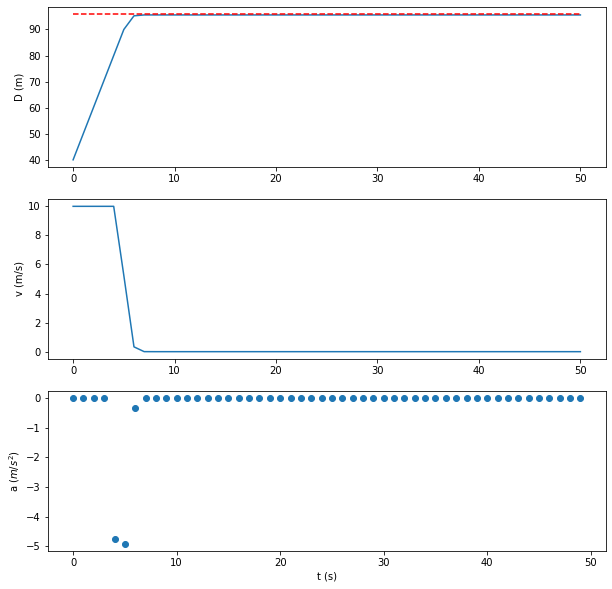

In [ ]:
import matplotlib.pyplot as plt

x0    = np.array([40,10])
T     = 50 #simulation horizon
N     = 1 # Prediction horizon
vref  =20 # reference speed
allow_reverse=False
simulator = SIMULATOR(dt=Ts,allow_reverse=allow_reverse)
Xf={'type':'cvxhull','SS':V}
p={'type':'cvxhull', 'patsamples':cost_fun}

x_cl,uOpt,xPred,feas,cost_cl= sim_mpc(x0,N,T,vref,allow_reverse,Xf)

# plot results
t_array = range(T+1) #+1
f = plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(t_array, x_cl[0, :])
plt.plot(t_array, x_cl[0, :]*0+ d_bike - l_car/2 - w_bike,'r--')
plt.ylabel('D (m)')
#plt.xlim([0,30])
plt.subplot(3,1,2)
#plt.xlim([0,30])
plt.plot(t_array, x_cl[1, :])
plt.ylabel('v (m/s)')
plt.subplot(3,1,3)
plt.plot(t_array[:-1], uOpt[0,:],'o')
plt.ylabel('a ($m/s^2$)')
#plt.xlim([0,30])
#plt.ylim([-1,2])
plt.xlabel('t (s)')
plt.show()